In [1]:
import os
from pathlib import Path
if '_cwd' not in locals():
    _cwd = os.getcwd()
    os.chdir(Path(_cwd)/'..')
    os.chdir(Path(os.getcwd())/'..') # ew

from explain.gradcam_heatmap_trajectories import compute_gradcam_and_pca, plot_heatmaps_per_label_and_component,plot_all_trajectories_with_and_without_heatmaps, compute_binned_heatmaps_per_label_and_component
from deep_traffic_generation.core.datasets import TrafficDataset
from sklearn.preprocessing import MinMaxScaler
from explain.gradcam_heatmap_trajectories import load_data_and_model, compute_gradcam_per_sample, perform_pca_on_latent_vectors, compute_projected_gradcam_activations


# enable autoreload     
%load_ext autoreload    
%autoreload 2

In [2]:
# Define your parameters here
positions_path = 'data/symbols/augmented_symbols.npy'
labels_path = 'data/symbols/augmented_labels.npy'

target_layer = 'encoder.0.layers.6'
device = 'cuda'  # or 'cuda' if you have a GPU
model_path = r'models\symbols.ckpt'

In [3]:
import numpy as np
positions = np.load(positions_path, allow_pickle=True)
labels = np.load(labels_path, allow_pickle=True)
positions.shape, labels.shape

((1100, 60, 2), (1100,))

In [4]:
dataset, labels, unique_labels, model, gcam = load_data_and_model(
    positions_path, labels_path, model_path, target_layer, device
)

gradcam_activations, sample_labels, mu_list, positions_array = compute_gradcam_per_sample(
    dataset, labels, model, gcam, device
)

pca, pca_latent = perform_pca_on_latent_vectors(mu_list, n_components=2)
gradcam_projections = compute_projected_gradcam_activations(gradcam_activations, pca)

Positions shape: (1100, 2, 60)
Labels shape: (1100,)
Unique labels: ['(' ')' '\\Omega']
Computing Grad-CAM activations for all samples...


Grad-CAM Computation: 100%|██████████| 1100/1100 [01:12<00:00, 15.27it/s]


Performing PCA on latent vectors with 2 components...
Explained variance ratios: [0.24603592 0.2366755 ]
Explained variance: [6.4307857 6.1861267]
Components shape: (2, 16)
Grad-CAM activations shape before projection: (1100, 60, 16)
Grad-CAM projections shape: (1100, 60, 2)


In [5]:
(heatmaps_dict,
 (global_x_min, global_x_max),
 (global_y_min, global_y_max),
 global_min, global_max) = compute_binned_heatmaps_per_label_and_component(
     positions_array,
     gradcam_projections,
     sample_labels,
     unique_labels,
     n_components=2,
     grid_size=200,
     bin_stats='mean',
     sigma=5,
     norm=True
)

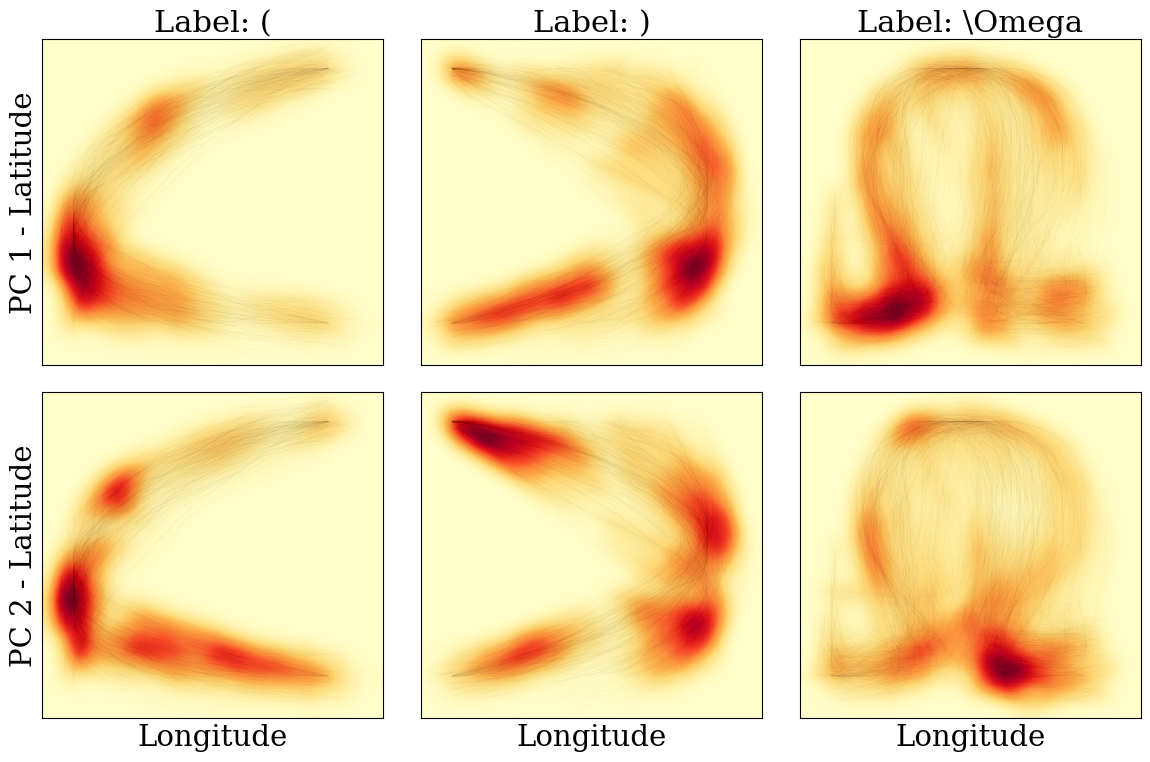

In [6]:
import matplotlib.pyplot as plt
font_offset = 10
plt.rcParams.update({
    "text.usetex": False,          # Enable LaTeX rendering
    "font.family": "serif",       # Use serif fonts
    "font.size": 11 + font_offset,              # Base font size
    "axes.titlesize": 12 + font_offset,         # Titles slightly larger
    "axes.labelsize": 11 + font_offset,         # Axis labels size
    "xtick.labelsize": 11 + font_offset ,         # Tick labels size
    "ytick.labelsize": 11 + font_offset,
    "legend.fontsize": 11+ font_offset,
})

plot_heatmaps_per_label_and_component(
    heatmaps_dict,
    positions_array,
    sample_labels,
    unique_labels,
    n_components=2,
    x_range=(global_x_min, global_x_max),
    y_range=(global_y_min, global_y_max),
    global_min=global_min,
    global_max=global_max,
    invert_y_axis=True,
    vertical_layout=True
)


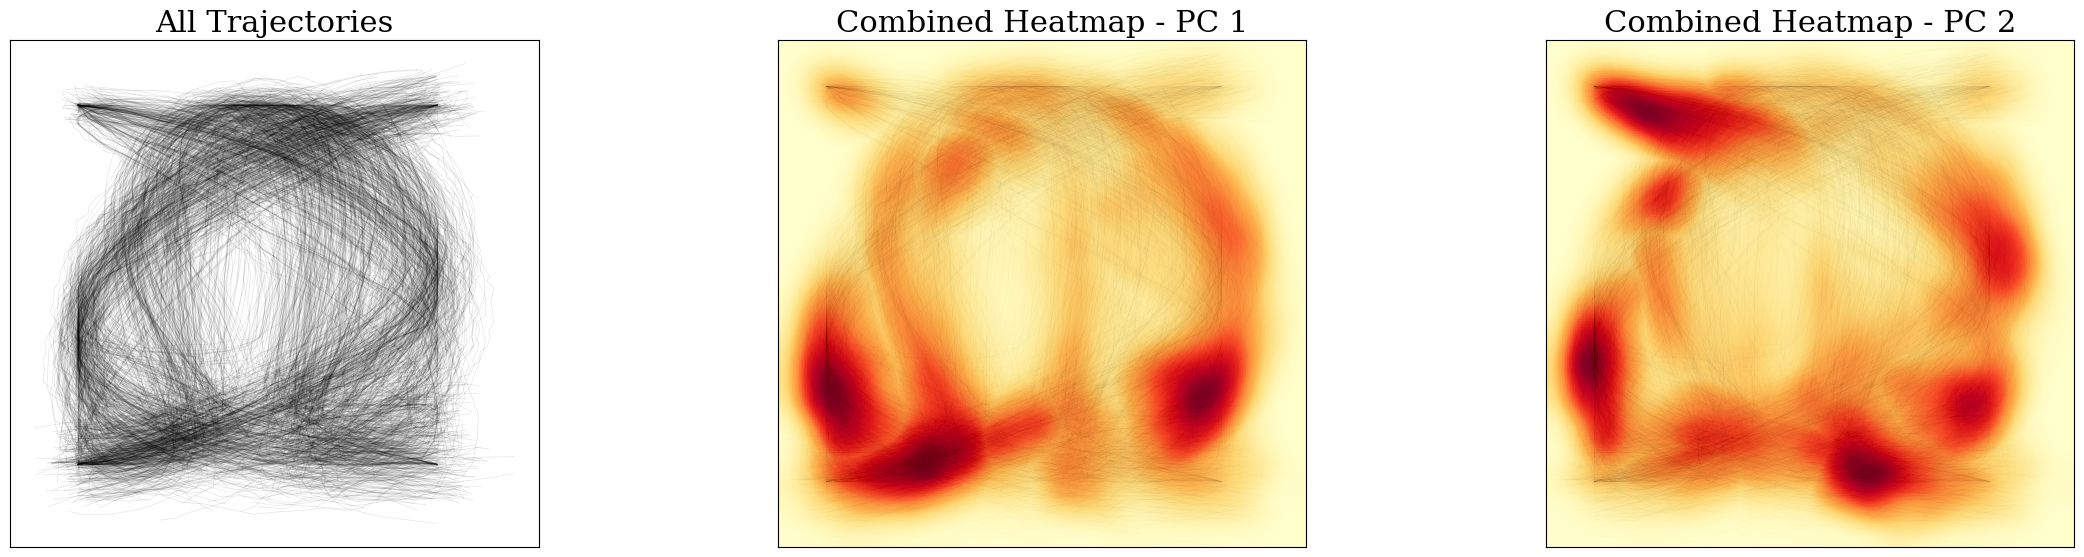

In [7]:
plot_all_trajectories_with_and_without_heatmaps(
    heatmaps_dict,
    positions_array,
    sample_labels,
    unique_labels,
    n_components=2,
    x_range=(global_x_min, global_x_max),
    y_range=(global_y_min, global_y_max),
    global_min=global_min,
    global_max=global_max,
    invert_y_axis=True,
    concat_fun=np.maximum
)


Threshold value (percentile 10) from mean gradcam: -0.0040086333872750395
Threshold value (percentile 20) from mean gradcam: -0.0017649699002504342
Threshold value (percentile 30) from mean gradcam: 0.0003355000866577025
Threshold value (percentile 40) from mean gradcam: 0.002751840790733695
Threshold value (percentile 50) from mean gradcam: 0.003252242458984256
Threshold value (percentile 60) from mean gradcam: 0.003961148019880056
Threshold value (percentile 70) from mean gradcam: 0.005679227225482463
Threshold value (percentile 80) from mean gradcam: 0.009492429159581662
Threshold value (percentile 90) from mean gradcam: 0.011466341279447078
Threshold value (percentile 99) from mean gradcam: 0.01192937420681119


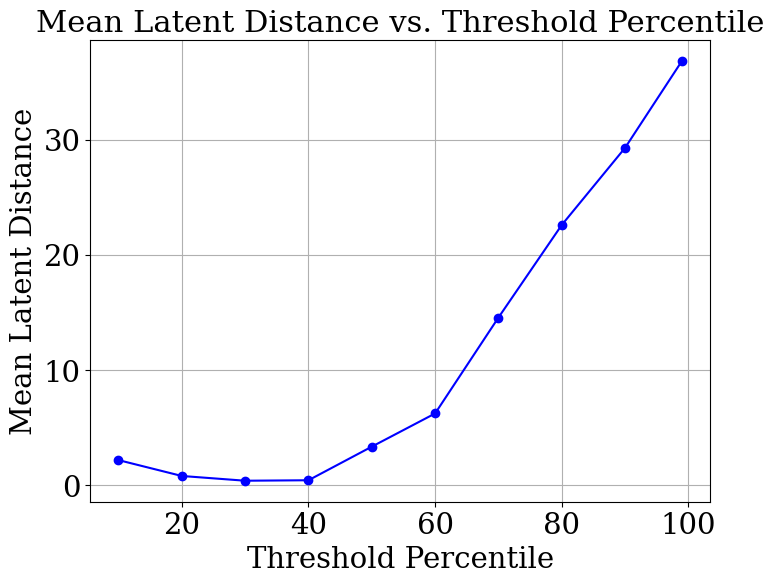

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from explain.gradcam_heatmap_trajectories import compute_global_latent_distance

# Define threshold percentiles: 10, 20, ..., 90
percentiles = np.arange(10, 100, 10)
# Add 99 
percentiles = np.append(percentiles, 99)
mean_distances = []

for perc in percentiles:
    mean_dist, dists = compute_global_latent_distance(
        percentile=perc,
        gradcam_first_pc=gradcam_projections[:, :, 0],  # shape: (num_samples, seq_len)
        positions_array=positions_array,
        sample_labels=sample_labels,
        model=model,
        pca=pca,
        original_latents=pca_latent,  # Ensure this is your PCA-projected latent vectors array
        selected_label='\Omega',
        device=device
    )
    mean_distances.append(mean_dist)

# Plot the line plot
plt.figure(figsize=(8, 6))
plt.plot(percentiles, mean_distances, marker='o', linestyle='-', color='b')
plt.xlabel("Threshold Percentile")
plt.ylabel("Mean Latent Distance")
plt.title("Mean Latent Distance vs. Threshold Percentile")
plt.grid(True)
plt.show()


In [ ]:
# Save the relults df
import pandas as pd
results_df = pd.DataFrame({
    'Threshold Percentile': percentiles,
    'Mean Latent Distance': mean_distances
})
results_df.to_parquet('data/symbols/mean_latent_distance_global.parquet', index=False)